In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rdkit import Chem, RDConfig
from rdkit.Chem import AllChem, ChemicalFeatures
from openpharmacophore.utils.rdkit_to_point import rdkit_to_point
from openpharmacophore import pharmacophoric_elements
import os
import numpy as np
import pyunitwizard as puw

### Testing for feature centroid

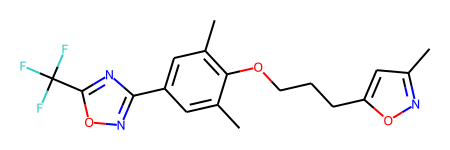

In [3]:
mol = Chem.MolFromSmiles("CC1=CC(=CC(=C1OCCCC2=CC(=NO2)C)C)C3=NOC(=N3)C(F)(F)F")
mol

In [4]:
mol.GetNumConformers()

0

In [5]:
def feature_centroid(molecule, atom_indxs, conformer_idx):
    """
       Get the 3D coordinates of the centroid of a feature that encompasses
       more than one atom. This could be aromatic, hydrophobic, negative and positive features
    """
    
    n_atoms = len(atom_indxs)
    coords = np.zeros((n_atoms, 3))
    for j, idx in enumerate(atom_indxs):
            position = molecule.GetConformer(conformer_idx).GetAtomPosition(idx)
            coords[j, 0] = position.x
            coords[j, 1] = position.y
            coords[j, 2] = position.z
    
    centroid = coords.mean(axis=0)
   
    return centroid

In [6]:
def generate_conformers(molecule, n_conformers, random_seed=-1, alignment=False):
    """Generate n conformers for a molecule"""
    molecule = Chem.AddHs(molecule) # Add hydrogens to generate realistic geometries
    cids = AllChem.EmbedMultipleConfs(molecule, numConfs=n_conformers, randomSeed=random_seed)
    
    if alignment:
        AllChem.AlignMolConformers(molecule)
    return molecule

In [7]:
mol = generate_conformers(mol, 1, random_seed=1, alignment=False)

fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)

feats = factory.GetFeaturesForMol(mol)
for f in feats:
        feat_name = f.GetFamily()
        atom_idxs = f.GetAtomIds()
        print(f"{feat_name}, atoms: {atom_idxs}")

Acceptor, atoms: (7,)
Acceptor, atoms: (14,)
Acceptor, atoms: (19,)
Acceptor, atoms: (22,)
Aromatic, atoms: (11, 12, 13, 14, 15)
Aromatic, atoms: (18, 19, 20, 21, 22)
Aromatic, atoms: (1, 2, 3, 4, 5, 6)
Hydrophobe, atoms: (0,)
Hydrophobe, atoms: (1,)
Hydrophobe, atoms: (2,)
Hydrophobe, atoms: (3,)
Hydrophobe, atoms: (4,)
Hydrophobe, atoms: (5,)
Hydrophobe, atoms: (9,)
Hydrophobe, atoms: (10,)
Hydrophobe, atoms: (12,)
Hydrophobe, atoms: (16,)
Hydrophobe, atoms: (17,)
LumpedHydrophobe, atoms: (1, 2, 3, 4, 5, 6)


In [8]:
idxs = (11, 12, 13, 14, 15)
x = 0
y = 0
z = 0
for i in idxs:
    pos = mol.GetConformer(0).GetAtomPosition(i)
    x += pos.x
    y += pos.y
    z += pos.z

x /= len(idxs)
y /= len(idxs)
z /= len(idxs)

print(x, y, z)
centroid = np.array([x,y,z])

-5.256026015194413 0.2637169048998521 -0.22204282175815981


In [9]:
x, y, z = -5.256026015194413, 0.2637169048998521, -0.22204282175815981

In [10]:
print(x == feature_centroid(mol, idxs, 0)[0])
print(y == feature_centroid(mol, idxs, 0)[1])
print(z == feature_centroid(mol, idxs, 0)[2])

True
True
True


### Testing rdkit_to_point

In [11]:
aromatic_sphere = rdkit_to_point("Aromatic", [0.0, 1.0, 1.0], radius=1.0)  
print(isinstance(aromatic_sphere, pharmacophoric_elements.AromaticRingSphere))
print(aromatic_sphere.radius == puw.standardize(puw.quantity(1.0, "angstroms")))
print(aromatic_sphere.feature_name == "aromatic ring")
print(np.all(aromatic_sphere.center == puw.standardize(puw.quantity([0.0, 1.0, 1.0], "angstroms"))))

True
True
True
True


In [12]:
r = puw.quantity(1, "angstroms")
puw.standardize(r)

0.09999999999999999 <Unit('nanometer')>